In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse
from astropy.stats import sigma_clipped_stats
from photutils.isophote import EllipseGeometry,Ellipse,build_ellipse_model
import matplotlib as mpl
import scipy.ndimage as im

In [2]:
galaxies={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9379': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}
SN_pos={'NGC3705': SkyCoord("11:30:05.940 +09:16:57.37",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:54.600 +30:16:17.40",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:04.895 +32:44:01.73",unit=('hourangle,deg')),
         'UGC9379': SkyCoord("14:33:57.009 +40:14:37.62",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57.173 +40:23:55.14",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44.400 +62:09:44.17",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:50.515 +12:41:44.20",unit=('hourangle,deg'))}
def Coord_Rotator(x,y,pa):
    x_rot=x*np.cos(pa*(np.pi/180))-y*np.sin(pa*(np.pi/180))
    y_rot=x*np.sin(pa*(np.pi/180))+y*np.cos(pa*(np.pi/180))
    return x_rot,y_rot
def Padded_Coord_Rotator(x,y,pa,padX,padY):
    x_new=x-padX[1]
    y_new=y-padY[1]
    x_rot=x_new*np.cos(pa*(np.pi/180))-y_new*np.sin(pa*(np.pi/180))
    y_rot=x_new*np.sin(pa*(np.pi/180))+y_new*np.cos(pa*(np.pi/180))
    x_rot+=padX[0]+padX[1]
    y_rot+=padY[0]+padY[1]
    return x_rot,y_rot

In [3]:
target='NGC3705'
im_test=f'./WCS_Solved/{target}/{target}_R.fits'
image=fits.open(im_test)[0].data
hdr=fits.open(im_test)[0].header
wcs=WCS(hdr)
data=image.byteswap().newbyteorder()
gal_x_init,gal_y_init=wcs.world_to_pixel(galaxies[target])
sn_x,sn_y=wcs.world_to_pixel(SN_pos[target])

In [4]:
bkg = sep.Background(data)
data_sub=data-bkg.globalback
objects,seg_map = sep.extract(data_sub, 3, err=bkg.globalrms,segmentation_map=True,deblend_cont=1)#use if no blending wanted
dists=np.sqrt((objects['x']-gal_x_init)**2+(objects['y']-gal_y_init)**2)
obj=np.argmin(dists)
x=objects['x'][obj]
y=objects['y'][obj]
a=objects['a'][obj]
b=objects['b'][obj]
theta=objects['theta'][obj]
obj_seg=seg_map[int(y),int(x)]
bkg_mask=np.zeros(data.shape,dtype=bool)
masked_pixels=0
for i in range(len(data)):
    for j in range(len(data[i])):
        if seg_map[i][j]!=0:
            bkg_mask[i][j]=True
            masked_pixels+=1
newbkg=sep.Background(data,mask=bkg_mask)
bkg_mean,bkg_med,bkg_std=sigma_clipped_stats(newbkg,sigma=2)
print(bkg_mean,bkg_med,bkg_std)

470.6333995496075 470.80047607421875 1.751233806493899


In [5]:
test=image.copy()
trues=0
for i in range(len(test)):
    for j in range(len(test[i])):
        #if seg_map[i][j]!=0:
        if (seg_map[i][j]!=obj_seg) and seg_map[i][j]!=0: 
        #if (seg_map[i][j]!=obj_seg) and (seg_map[i][j]!=obj_seg+1)and seg_map[i][j]!=0: for NGC3705, replace previous
            test[i][j]=bkg_med
            trues+=1
print(trues)

65963


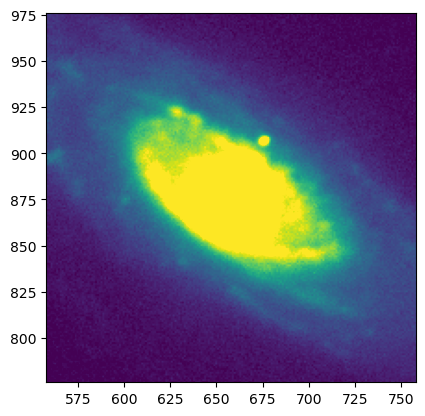

In [6]:
iso_data=test-bkg_med
plt.imshow(iso_data,vmin=0,vmax=500)
tol=100
plt.ylim(int(y)-tol,int(y)+tol)
plt.xlim(int(x)-tol,int(x)+tol)
geo=EllipseGeometry(x,y,a,np.sqrt(1-(b/a)**2),theta)
ellipse = Ellipse(iso_data, geo)
isos = ellipse.fit_image()
model_image = build_ellipse_model(iso_data.shape, isos)
residual = iso_data - model_image

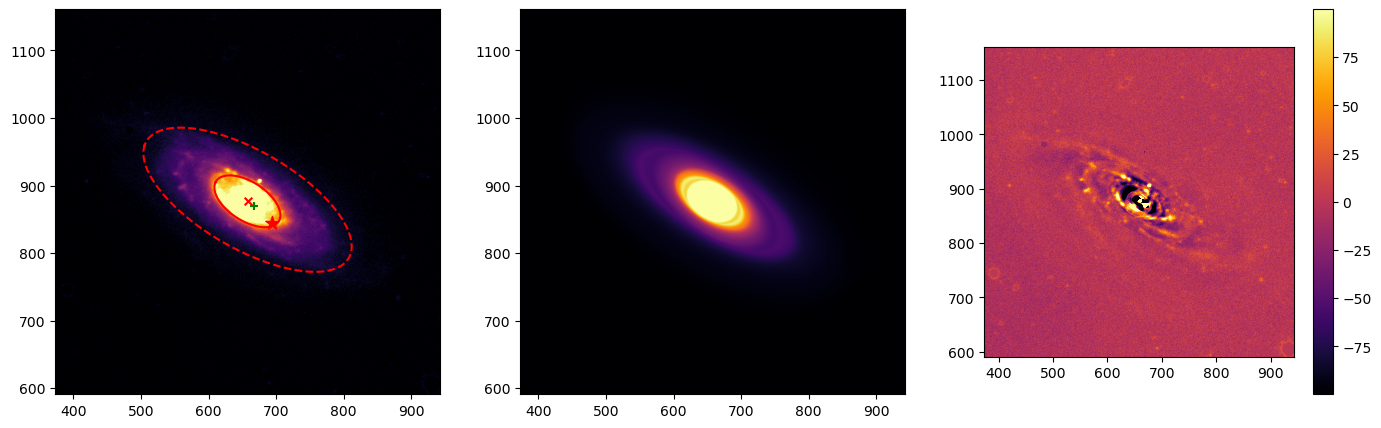

In [7]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,5))
tol=int(0.7*np.max(isos.sma))
ax1.imshow(iso_data,vmin=0,vmax=500,cmap='inferno')
ax1.set_ylim(int(y)-tol,int(y)+tol)
ax1.set_xlim(int(x)-tol,int(x)+tol)
half_flux=0.5*np.nanmax(isos.tflux_e)
iso_ind_50=np.nanargmin([np.abs(el-half_flux) for el in isos.tflux_e])
sma_r50=isos.sma[iso_ind_50]
iso_50=isos.get_closest(sma_r50)
x2,y2=iso_50.sampled_coordinates()
ax1.plot(x2,y2,color='r',zorder=10)
flux90=0.9*np.nanmax(isos.tflux_e)
iso_ind_90=np.nanargmin([np.abs(el-flux90) for el in isos.tflux_e])
sma_r90=isos.sma[iso_ind_90]
iso_90=isos.get_closest(sma_r90)
x3,y3=iso_90.sampled_coordinates()
ax1.plot(x3,y3,color='r',ls='--',zorder=10)
#iso=isos
ax2.imshow(model_image,vmin=0,vmax=500,cmap='inferno')
ax2.set_ylim(int(y)-tol,int(y)+tol)
ax2.set_xlim(int(x)-tol,int(x)+tol)
res_tol=10*sigma_clipped_stats(residual)[2]
ax3.imshow(residual,vmin=-res_tol,vmax=res_tol,cmap='inferno')
cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=-res_tol, vmax=res_tol)
ax3.set_ylim(int(y)-tol,int(y)+tol)
ax3.set_xlim(int(x)-tol,int(x)+tol)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax3)
ax1.scatter(sn_x,sn_y,[100],marker='*',color='red')
ax1.scatter(np.median(isos.x0),np.median(isos.y0),[30],marker='x',color='red')
pix_max=np.unravel_index(np.argmax(iso_data),iso_data.shape)
ax1.scatter(pix_max[1],pix_max[0],[30],marker='+',color='green')


[  0.          27.28392793  27.61551335  28.11555818  28.41873671
  28.87412215  27.3656789   25.87769601  24.09361731  23.15276118
  22.62809725  22.53544984  24.74444586  28.2233221   28.61014531
  26.59953962  25.89946983  22.82317521  20.63039758  21.7870792
  22.97538753  21.68111177  22.82154399  19.40266428  22.27059407
 126.98522827 147.22200279 147.22200279 147.22200279 147.22200279
 147.22200279 147.22200279 147.22200279 147.22200279 147.22200279
 144.19908662 144.19908662 146.31092118 149.17563222 149.17563222
 147.21316547 148.25522357 174.15639851 147.22200279 147.22200279
 150.00156618 150.00156618 150.00156618 150.00156618 147.22200279
 147.22200279 146.1801538  146.1801538  146.1801538  145.16596675
 143.96856775 143.96856775 143.96856775 147.38779656 149.02934987
 148.55003066 148.78675874 150.0934475  150.58224181 150.58224181
 148.40673034 148.40673034 148.40673034 139.98364741 124.87575405
 124.87575405 124.87575405]


29.906552501115414
[1389, 659] [1177, 877]
0.4198639417335793
0.14196430163339427
Offset=  194.46066700717708 "
R_90= 473.5345924385009 "
R_50= 168.3961115142533 "


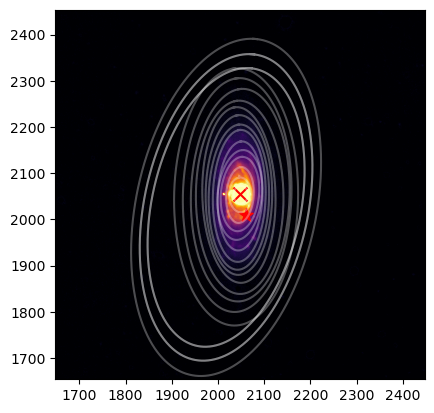

In [9]:
val=isos.pa[iso_ind_90]*(180/np.pi)
if val<90:
    pa=val
else:
    pa=180-val
tol=400
print(pa)
padX = [iso_data.shape[1] - round(x), round(x)]
padY = [iso_data.shape[0] - round(y), round(y)]
print(padX,padY)
Padded = np.pad(iso_data, [padY, padX], 'constant')
rot_im=im.rotate(Padded,-pa-90,reshape=False)
plt.imshow(rot_im,vmin=0,vmax=700,cmap='inferno')
plt.xlim(padX[0]+x-tol,padX[0]+x+tol)
plt.ylim(padY[0]+y-tol,padY[0]+y+tol)
sn_x_adj,sn_y_adj=Padded_Coord_Rotator(sn_x,sn_y,-pa,padX,padY)
gal_x_med,gal_y_med=Padded_Coord_Rotator(np.median(isos.x0),np.median(isos.y0),-pa,padX,padY)
plt.scatter(sn_x_adj,sn_y_adj,[100],marker='*',color='red')
plt.scatter(gal_x_med,gal_y_med,[100],marker='x',color='red')
cos_i=(((1-isos.eps[iso_ind_90])**2-(0.2**2)))/(1-0.2**2)
print(1-isos.eps[iso_ind_90])
print(cos_i)
print('Offset= ',np.sqrt((sn_x_adj-gal_x_med)**2+((sn_y_adj-gal_y_med)/cos_i)**2)*0.6,'\"')
R_50=(sma_r50/cos_i)*np.sqrt((1-isos.eps[iso_ind_50]))
R_90=(sma_r90/cos_i)*np.sqrt((1-isos.eps[iso_ind_90]))
#R_50=np.sqrt((sma_r50**2)*np.sqrt(1-isos.eps[iso_ind_50]**2))
#R_90=np.sqrt((sma_r90**2)*np.sqrt(1-isos.eps[iso_ind_90]**2))
print('R_90=',R_90*0.6,'\"')
print('R_50=',R_50*0.6,'\"')
geo1=EllipseGeometry(gal_x_med,gal_y_med,a,1-(b/a),theta-isos.pa[iso_ind_90]+np.pi/2)
ellipse1 = Ellipse(rot_im, geo1)
isos1 = ellipse1.fit_image()
smas = np.linspace(np.min(isos1.sma), np.max(isos1.sma), 20)
for sma in smas:
    iso = isos1.get_closest(sma)
    x5, y5, = iso.sampled_coordinates()
    plt.plot(x5, y5, color='white',alpha=0.3)
# circle1 = plt.Circle((gal_x_med, gal_y_med), R_50, color='r',fill=False)
# circle2 = plt.Circle((gal_x_med, gal_y_med), R_90, color='r',fill=False,ls='--')
# plt.gca().add_patch(circle1)
# plt.gca().add_patch(circle2)


In [10]:
print(isos1.pa*(180/np.pi))

[  0.         175.52383572 174.65985051 173.75643609 171.08812734
 164.87550607 155.50243425 147.68284906 146.43317065 146.30115814
 146.22490421 145.93206345 145.16608309 145.05555004 144.86547404
 142.46323478 141.64158469 143.51850142 143.48456418 143.37056056
 143.2448274  141.60042565 141.8393329  124.05776866 152.12133046
  70.31158815  74.48051749  87.14927935  87.14927935  87.14927935
  87.14927935  84.2540211   84.2540211   84.2540211   84.2540211
  84.2540211   84.2540211   86.24416371  89.18539295  89.18539295
  87.18003668  88.46879286 115.55689206 100.35844172  91.36414288
  91.36414288  91.36414288  91.36414288  89.35288428  87.14927935
  87.14927935  86.16018892  86.28268035  86.28268035  85.01077909
  83.87031184  84.48916388  84.48916388  87.62306513  89.10971463
  88.39730001  88.76849548  89.51085871  91.54868576  90.3170261
  88.35731987  88.35731987  89.04949429  78.16747091  78.16747091
  78.16747091]


: 